# DeepWalk, LINE, and MetaPath on Citeseer in PyTorch

In [ ]:
!wget -q --show-progress https://github.com/sparsh-ai/stanza/raw/S629908/ind.citeseer.graph

ind.citeseer.graph  100%[===================>]  60.53K  --.-KB/s    in 0.001s  


In [ ]:
import numpy as np
import pandas as pd
import numpy.random as npr
import copy
import os
import pickle
import sys
import random
import math
import networkx as nx
from copy import deepcopy
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from operator import itemgetter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def make_graph_data(file_name, weighted, num_type_node):
    data = pd.read_pickle(file_name)
    graph = nx.Graph(data)

    if weighted:
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            graph[src][dst]['weight'] = np.random.randint(0, 100)
    else:
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            graph[src][dst]['weight'] = 1
    
    node_type = []
    if num_type_node:
        for node in graph.nodes():
            node_type.append(np.random.randint(num_type_node))
        return graph, node_type
        
    return graph,

In [ ]:
class SamplingAliasMethod:
    
    def __init__(self, probs):
        self.probs = np.array(probs) / np.sum(probs)
        self.K = len(probs)
        self.prob_arr = np.zeros(self.K)
        self.alias_arr = np.zeros(self.K, dtype=np.int32)
        self.create_alias_table_(probs)
        
    def create_alias_table_(self, probs):
        small = []
        large = []
        
        for b, prob in enumerate(self.probs):
            self.prob_arr[b] = prob*self.K

            if self.prob_arr[b] < 1:
                small.append(b)
            else:
                large.append(b)

        while small and large:
            s = small.pop()
            l = large.pop()

            self.alias_arr[s] = l
            self.prob_arr[l] = self.prob_arr[l] - (1 - self.prob_arr[s])

            if self.prob_arr[l] < 1:
                small.append(l)
            else:
                large.append(l)
    
    def sampling(self):
        bin_idx = int(np.floor(np.random.rand()*self.K))

        threshold = self.prob_arr[bin_idx]

        if np.random.rand() < threshold:
            return bin_idx
        else:
            return self.alias_arr[bin_idx]

    def return_sample(self,n_sample):
        return [self.sampling() for _ in range(n_sample)]

### DeelWalk

In [ ]:
class WalkDatset(Dataset):
    def __init__(self, graph, walk_length, window_size):
        self.graph = graph
        self.walk_length = walk_length
        self.window_size = window_size
        self.nodes = list(graph.nodes())

    def __len__(self):
        return len(self.nodes)

    def random_walk(self, graph, node, walk_length):
        src = node
        walk = [src]
        for i in range(walk_length):
            dst = list(dict(graph[src]).keys())
            src = np.random.choice(dst)
            walk.append(src)
        return walk
    
    def __getitem__(self, idx):
        node = self.nodes[idx]
        walk = self.random_walk(self.graph, node, self.walk_length)
        target_idx, context_idx = [],[]
        for i, target in enumerate(walk):
            left_window = walk[max(i-self.window_size, 0):i]
            right_window = walk[i+1:i+1+self.window_size]
            contexts = left_window + right_window
            
            target_idx.extend([target] * len(contexts))
            context_idx.extend(contexts)
        
        return {'target':torch.LongTensor(target_idx), 'context':torch.LongTensor(context_idx)}

In [ ]:
class DeepWalk(nn.Module):
    def __init__(self, nodes, emb_dim, device):
        super(DeepWalk, self).__init__()
        self.embed = nn.Embedding(len(nodes), emb_dim)
        self.all_node = torch.LongTensor(list(nodes)).to(device)
        # torch.nn.init.normal_(self.embed.weight, mean=0, std=0.02)

    def hier_softmax(self,):
        return 

    def forward(self, target, context):
        batch_size, _ = target.size()
        # print(_)
        embed_t = self.embed(target)
        embed_c = self.embed(context)
        embed_all = self.embed(self.all_node).T.unsqueeze(0).repeat(batch_size, 1, 1)
        score = torch.exp(torch.sum(torch.mul(embed_t, embed_c), axis=2))
        scale = torch.sum(torch.exp(torch.bmm(embed_t, embed_all)), axis=2)
        loss = -torch.log(score / scale)
        # print(loss.shape)

        return torch.mean(torch.mean(loss, axis=1))

In [ ]:
class Config:
    learning_rate = 0.001
    weight_decay = 0.01
    epochs = 10
    seed = 1995
    embed_dim = 30
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    batch_size = 128
    walk_len = 20
    num_walk_per_node = 100
    window_size = 5

config = Config()

EPOCH 1 : Loss 23.660794038038986
EPOCH 10 : Loss 16.49889982663668
EPOCH 20 : Loss 11.592923567845272
EPOCH 30 : Loss 9.049788034879244
EPOCH 40 : Loss 8.016361695069532
EPOCH 50 : Loss 7.7146247166853685
EPOCH 60 : Loss 7.712115196081308
EPOCH 70 : Loss 7.796583579136775
EPOCH 80 : Loss 7.879110079545241
EPOCH 90 : Loss 7.952493044046255
EPOCH 100 : Loss 8.005689272513756
0:04:14.126420


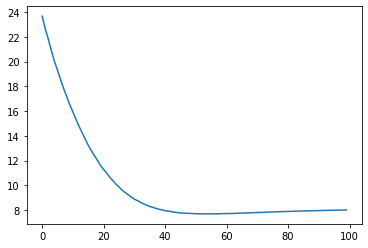

In [ ]:
graph = make_graph_data('ind.citeseer.graph', weighted=False, num_type_node=False)[0]
config.tree_depth = int(np.ceil(np.log2(graph.number_of_nodes())))

dataset = WalkDatset(graph, config.walk_len, config.window_size)
dataloader = DataLoader(dataset, batch_size=config.batch_size, drop_last=False, shuffle=True)

model = DeepWalk(graph.nodes(), config.embed_dim, config.device)
model = model.to(config.device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

history = defaultdict(list)
start = datetime.now()
for epoch in range(config.num_walk_per_node):
    losses = []
    model.train()
    for batch_data in dataloader:
        optimizer.zero_grad()
        target, context = batch_data['target'].to(config.device), batch_data['context'].to(config.device)
        loss = model(target, context)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0 or epoch==0 or (epoch+1)==config.num_walk_per_node:
        print(f'EPOCH {epoch+1} : Loss', np.mean(losses))
    history['train'].append(np.mean(losses))

end = datetime.now()
print(end-start)
plt.plot(history['train'])

### LINE

In [ ]:
dd = defaultdict(int)
for _ in range(2000):
    dd[np.random.randint(4)] += 1

def make_graph_data(file_name, weighted, num_type_node):
    data = pd.read_pickle(file_name)
    graph = nx.Graph(data)

    if weighted:
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            graph[src][dst]['weight'] = np.random.randint(0, 100)
    else:
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            graph[src][dst]['weight'] = 1
    
    node_type = []
    if num_type_node:
        for node in graph.nodes():
            node_type.append(np.random.randint(num_type_node))
        return graph, node_type
        
    return graph

In [ ]:
class SamplingAliasMethod:
    
    def __init__(self, probs):
        self.probs = np.array(probs) / np.sum(probs)
        self.K = len(probs)
        self.prob_arr = np.zeros(self.K)
        self.alias_arr = np.zeros(self.K, dtype=np.int32)
        self.create_alias_table_(probs)
        
    def create_alias_table_(self, probs):
        small = []
        large = []
        
        for b, prob in enumerate(self.probs):
            self.prob_arr[b] = prob*self.K

            if self.prob_arr[b] < 1:
                small.append(b)
            else:
                large.append(b)

        while small and large:
            s = small.pop()
            l = large.pop()

            self.alias_arr[s] = l
            self.prob_arr[l] = self.prob_arr[l] - (1 - self.prob_arr[s])

            if self.prob_arr[l] < 1:
                small.append(l)
            else:
                large.append(l)
    
    def sampling(self):
        bin_idx = int(np.floor(np.random.rand()*self.K))

        threshold = self.prob_arr[bin_idx]

        if np.random.rand() < threshold:
            return bin_idx
        else:
            return self.alias_arr[bin_idx]

    def return_sample(self,n_sample):
        return [self.sampling() for _ in range(n_sample)]

In [ ]:
graph = make_graph_data('ind.citeseer.graph', weighted=True, num_type_node=False)

In [ ]:
class Config:
    learning_rate_f = 0.005
    learning_rate_s = 0.01
    epoch_f = 200
    epoch_s = 30
    epochs = max(epoch_f, epoch_s)

    weight_decay = 0.01
    seed = 1995
    embed_dim = 30
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 128
    neg_sampling_per_pos = 5
    num_batch_per_epoch = graph.number_of_edges() // batch_size
    order = 'all'

config = Config()

In [ ]:
class Dataset:
    def __init__(self, graph, batch_size, neg_sampling_per_pos):
        self.graph = graph
        self.neg_sampling_per_pos = neg_sampling_per_pos
        self.edge_info, self.node_info = self.get_graph_info(graph)
        self.node_sampler = SamplingAliasMethod(self.node_info[1])
        self.edge_sampler = SamplingAliasMethod(self.edge_info[1])
        
        self.edge_num = len(self.edge_info[0])
        self.node_num = len(self.node_info[0])

        self.batch_size = batch_size
        self.edge_w = np.array(self.edge_info[1]) / np.sum(self.edge_info[1])
    
    def get_graph_info(self, graph):
        edge_idx, edge_weight = [], []
        node_degree = defaultdict(int)
        
        for edge in self.graph.edges():
            src = edge[0]
            dst = edge[1]

            edge_idx.append(edge)
            edge_weight.append(self.graph[src][dst]['weight'])

            node_degree[src] += self.graph[src][dst]['weight']

        node_idx, node_weight = np.arange(graph.number_of_nodes()), np.zeros(graph.number_of_nodes())
        for n, d in node_degree.items():
            node_weight[n] = np.power(d, 3/4)

        return (edge_idx, edge_weight), (node_idx, node_weight)
    
    def get_graph_info(self, graph):
        edge_idx, edge_weight = [], []
        node_degree = defaultdict(int)
        
        for edge in self.graph.edges():
            src = edge[0]
            dst = edge[1]

            edge_idx.append(edge)
            edge_weight.append(self.graph[src][dst]['weight'])

            node_degree[src] += self.graph[src][dst]['weight']

        node_idx, node_weight = [], []
        for n, d in node_degree.items():
            node_idx.append(n)
            node_weight.append(np.power(n, 3/4))

        return (edge_idx, edge_weight), (node_idx, node_weight)
    
    def get_batch(self,):
        # positive edge sampling
        sampled_edge_idx = self.edge_sampler.return_sample(self.batch_size)
        # for _ in range(self.edge_num // self.batch_size + 1):
        pos = [self.edge_info[0][a] for a in sampled_edge_idx] 
        pos_weight = [self.edge_w[a] for a in sampled_edge_idx] 
        # negative edge sampling
        neg= []
        for i, s in enumerate(pos):
            src = s[0]
            neg_sampled = self.node_sampler.return_sample(self.neg_sampling_per_pos)
            neg_edges = [(src, self.node_info[0][a]) for a in neg_sampled]
            neg.extend(neg_edges)
        
        return {'pos':torch.tensor(pos, dtype=torch.long).to(config.device),
                'pos_w':torch.tensor(pos_weight, dtype=torch.float).to(config.device),
                'neg':torch.tensor(neg, dtype=torch.long).to(config.device),
                }

In [ ]:
class LINE(nn.Module):
    def __init__(self, order, K_neg, small_d, n_node, device):
        super(LINE, self).__init__()
        
        self.order = order

        if order == 'first':
            self.embed_1 = nn.Embedding(n_node, small_d)
        elif order == 'second':
            self.embed_2 = nn.Embedding(n_node, small_d)
            self.embed_2_context = nn.Embedding(n_node, small_d)
        else:
            self.embed_1 = nn.Embedding(n_node, small_d)
            self.embed_2 = nn.Embedding(n_node, small_d)
            self.embed_2_context = nn.Embedding(n_node, small_d)

    def forward(self, batch_data):
        pos_edge = batch_data['pos']
        pos_edge_w = batch_data['pos_w']
        neg_edge = batch_data['neg']
        pos_src, pos_dst = pos_edge[:, 0], pos_edge[:, 1]
        neg_src, neg_dst = neg_edge[:, 0], neg_edge[:, 1]

        if self.order == 'first':
            return {'first':self.first_loss(pos_src, pos_dst, pos_edge_w), 'second':0}
        
        if self.order == 'second':
            return {'second':self.second_loss(pos_src, pos_dst, neg_src, neg_dst), 'first':0}

        if self.order == 'all':
            return {
                'first':self.first_loss(pos_src, pos_dst, pos_edge_w),
                'second':self.second_loss(pos_src, pos_dst, neg_src, neg_dst)
            }
    
    def first_loss(self, pos_src, pos_dst, pos_edge_w):
        ui = self.embed_1(pos_src)
        uj = self.embed_1(pos_dst)
        pvivj = torch.sigmoid(torch.sum(ui * uj, axis=1))
        loss = -torch.sum(pos_edge_w * torch.log(pvivj))
        return loss
    
    def second_loss(self, pos_src, pos_dst, neg_src, neg_dst):
        ui = self.embed_2(pos_src)
        ujp = self.embed_2_context(pos_dst)
        pos_loss = torch.sum(torch.log(torch.sigmoid(torch.sum(ui * ujp, axis=1))))
        
        ui = self.embed_2(neg_src)
        ujp = self.embed_2_context(neg_dst)
        neg_loss = torch.sum(torch.log(torch.sigmoid(-torch.sum(ui * ujp, axis=1))))
        return -(pos_loss + neg_loss)
    
    def get_embeddings(self, node_idx):
        '''
        node_idx => torch.longtensor
        '''
        if self.order == 'first':
            return self.embed_1(node_idx)    
        if self.order == 'second':
            return self.embed_2(node_idx)  
        if self.order == 'all':
            return torch.cat([self.embed_1(node_idx), self.embed_2(node_idx)], axis=1)

def get_params_group(model, type):
    if type == 'first':
        optimizer_parameters = [{'params': [p for n,p in model.named_parameters() if 'embed_1' in n]}]
    if type == 'second':
        optimizer_parameters = [{'params': [p for n,p in model.named_parameters() if 'embed_2' in n]}]
    return optimizer_parameters

In [ ]:
dataset = Dataset(graph, batch_size=config.batch_size, neg_sampling_per_pos=config.neg_sampling_per_pos)
model = LINE(order=config.order, K_neg=5, small_d=30, n_node=graph.number_of_nodes(), device='cuda')
# model = model.to('cuda')

optimizer_f = optim.SGD(get_params_group(model, 'first'), lr=config.learning_rate_f, momentum=0.9)   
optimizer_s = optim.SGD(get_params_group(model, 'second'), lr=config.learning_rate_s, momentum=0.9)

start = datetime.now()
history_f, history_s = defaultdict(list), defaultdict(list)

for epoch in range(config.epochs):
    model.train()
    losses_f, losses_s = [], []
    for _ in range(config.num_batch_per_epoch):
        batch_data = dataset.get_batch()
        
        optimizer_f.zero_grad()
        optimizer_s.zero_grad()
        
        losses = model(batch_data)
        if (config.order == 'first' or config.order == 'all') and config.epoch_f >= epoch+1:
            loss_f = losses['first']
            loss_f.backward()
            optimizer_f.step()
            losses_f.append(loss_f.item())
        
        if (config.order == 'second' or config.order == 'all') and config.epoch_s >= epoch+1:
            loss_s = losses['second']
            losses_s.append(loss_s.item())    
            loss_s.backward()
            optimizer_s.step()
        
    display_f = f'Training ended at epoch {config.epoch_f}' if np.isnan(np.mean(losses_f)) else np.round(np.mean(losses_f), 6)
    display_s = f'Training ended at epoch {config.epoch_s}' if np.isnan(np.mean(losses_s)) else np.round(np.mean(losses_s), 6)

    history_f[epoch] = np.mean(losses_f)
    history_s[epoch] = np.mean(losses_s)

    if epoch == 0 or (epoch+1) % 10 == 0:
        print(f'EPOCH {epoch+1} TRAIN First Loss : {display_f}, TRAIN Second Loss : {display_s}')

EPOCH 1 TRAIN First Loss : 0.081494, TRAIN Second Loss : 1562.467404
EPOCH 10 TRAIN First Loss : 0.086245, TRAIN Second Loss : 169.425962
EPOCH 20 TRAIN First Loss : 0.082142, TRAIN Second Loss : 40.399059
EPOCH 30 TRAIN First Loss : 0.080529, TRAIN Second Loss : 24.339882
EPOCH 40 TRAIN First Loss : 0.080362, TRAIN Second Loss : Training ended at epoch 30
EPOCH 50 TRAIN First Loss : 0.082198, TRAIN Second Loss : Training ended at epoch 30
EPOCH 60 TRAIN First Loss : 0.080505, TRAIN Second Loss : Training ended at epoch 30
EPOCH 70 TRAIN First Loss : 0.081158, TRAIN Second Loss : Training ended at epoch 30
EPOCH 80 TRAIN First Loss : 0.083779, TRAIN Second Loss : Training ended at epoch 30
EPOCH 90 TRAIN First Loss : 0.081434, TRAIN Second Loss : Training ended at epoch 30
EPOCH 100 TRAIN First Loss : 0.082903, TRAIN Second Loss : Training ended at epoch 30
EPOCH 110 TRAIN First Loss : 0.079346, TRAIN Second Loss : Training ended at epoch 30
EPOCH 120 TRAIN First Loss : 0.080011, TRAIN

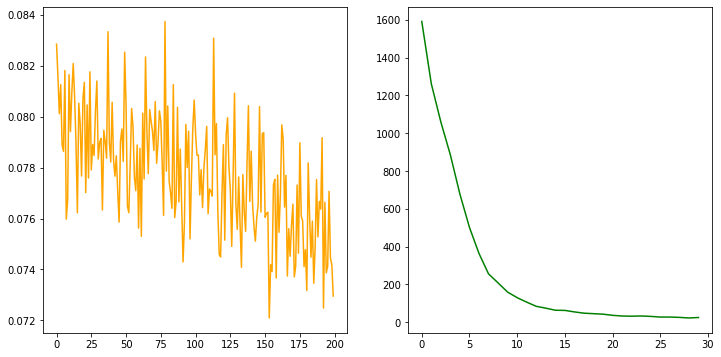

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
axes[0].plot(list(history_f.keys()), list(history_f.values()), color='orange')
axes[1].plot(list(history_s.keys()), list(history_s.values()), color='green')

In [ ]:
node_want_embed = torch.LongTensor([0, 1, 2, 3]).to(config.device)
model.get_embeddings(node_want_embed).shape

torch.Size([4, 60])

## Metapath

In [ ]:
dd = defaultdict(int)
for _ in range(2000):
    dd[np.random.randint(4)] += 1

def make_graph_data(file_name, weighted, num_type_node):
    data = pd.read_pickle(file_name)
    graph = nx.Graph(data)

    if weighted:
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            graph[src][dst]['weight'] = np.random.randint(0, 100)
    else:
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            graph[src][dst]['weight'] = 1
    
    node_type = []
    if num_type_node:
        for node in graph.nodes():
            node_type.append(np.random.randint(num_type_node))
        return graph, node_type
        
    return graph

class SamplingAliasMethod:
    
    def __init__(self, probs):
        self.probs = np.array(probs) / np.sum(probs)
        self.K = len(probs)
        self.prob_arr = np.zeros(self.K)
        self.alias_arr = np.zeros(self.K, dtype=np.int32)
        self.create_alias_table_(probs)
        
    def create_alias_table_(self, probs):
        small = []
        large = []
        
        for b, prob in enumerate(self.probs):
            self.prob_arr[b] = prob*self.K

            if self.prob_arr[b] < 1:
                small.append(b)
            else:
                large.append(b)

        while small and large:
            s = small.pop()
            l = large.pop()

            self.alias_arr[s] = l
            self.prob_arr[l] = self.prob_arr[l] - (1 - self.prob_arr[s])

            if self.prob_arr[l] < 1:
                small.append(l)
            else:
                large.append(l)
    
    def sampling(self):
        bin_idx = int(np.floor(np.random.rand()*self.K))

        threshold = self.prob_arr[bin_idx]

        if np.random.rand() < threshold:
            return bin_idx
        else:
            return self.alias_arr[bin_idx]

    def return_sample(self,n_sample):
        return [self.sampling() for _ in range(n_sample)]

EPOCH 1 : TRAINING Loss 10.391045570373535
EPOCH 2 : TRAINING Loss 7.830985069274902
EPOCH 3 : TRAINING Loss 9.028563499450684
EPOCH 4 : TRAINING Loss 6.874206066131592
EPOCH 5 : TRAINING Loss 5.779118061065674
EPOCH 6 : TRAINING Loss 4.590670108795166
EPOCH 7 : TRAINING Loss 3.1157608032226562
EPOCH 8 : TRAINING Loss 2.8097612857818604
EPOCH 9 : TRAINING Loss 2.578549385070801
EPOCH 10 : TRAINING Loss 3.7474987506866455


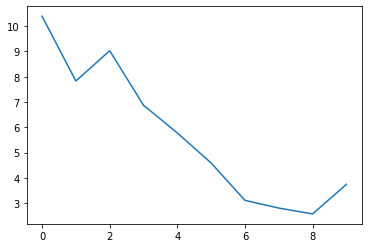

In [ ]:
class Config:
    learning_rate = 0.005
    weight_decay = 0.01
    epochs = 10
    seed = 1995
    embed_dim = 30
    k_neighbor = 5

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 128
    neg_sampling_per_pos = 5

    num_type_node = 2
    metapath = [0,1,0]
    walk_len = 20
    metapath_walk = metapath[:-1] * walk_len 
    num_walk_per_node = 1

config = Config()

graph, node_type = make_graph_data('./data/bronze/citeseer/ind.citeseer.graph', weighted=True, num_type_node=config.num_type_node)
config.node_type = np.array(node_type)

class metapath2vec(nn.Module):
    def __init__(self, graph, node_type):
        super(metapath2vec, self).__init__()
        self.graph = graph
        self.node_info = self.get_graph_info(graph)
        self.num_node = graph.number_of_nodes()
        self.X = nn.Embedding(self.num_node, config.embed_dim, device=config.device)
        self.logsig = nn.LogSigmoid()
        self.node_sampler = SamplingAliasMethod(self.node_info[1])
        self.node_type = node_type
        self.history = defaultdict(list)

    def get_graph_info(self,graph):
        node_degree = defaultdict(int)
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            node_degree[src] += graph[src][dst]['weight']
        
        node_idx, node_weight = np.arange(graph.number_of_nodes()), np.zeros(graph.number_of_nodes())
        for n, d in node_degree.items():
            node_weight[n] = np.power(d, 3/4)

        return (node_idx, node_weight)

    def get_batch_node_idx(self, batch_size):
        shuffled_node_idx = np.random.permutation(np.arange(self.num_node))
        num_batch = (self.num_node // batch_size) + 1
        batch_split = np.arange(1, num_batch) * batch_size
        return np.split(shuffled_node_idx, batch_split)

    def MetaPathRandomWalk(self, curr_node, node_type, metapath_walk):
        mp = [curr_node]
        curr_type = node_type[curr_node]
        metapath = metapath_walk[curr_type+1:]
        for i in range(config.walk_len):
            dst = np.array(graph[curr_node])
            dst_type = node_type[dst]
            Nv = dst[dst_type == metapath[i]]
            if len(Nv) == 0:
                return mp
            curr_node = np.random.choice(Nv, 1)[0]
            curr_type = node_type[curr_node]
            assert curr_type == metapath[i]

            mp.append(curr_node)
        
        return torch.tensor(mp).long().to(config.device)

    def get_positive_loss(self, v, ct):
        Xv = self.X(v)
        Xct = self.X(ct)
        pos_loss = -self.logsig(torch.sum(torch.mul(Xv, Xct)))
        return pos_loss

    def get_negative_loss(self, v, ut):
        Xv = self.X(v)
        Xut = self.X(ut)
        score = torch.sum(torch.mul(-Xv, Xut), axis=1)
        return -torch.sum(self.logsig(score))

    def HeterogeneousSkipGram(self, k, MP, optimizer):
        total_loss = 0
        n = 0
        for i in range(config.walk_len):
            v = MP[i]
            for j in range(i+1, min(i+1+k, config.walk_len)):
                ct = MP[j]
                pos_loss = self.get_positive_loss(v, ct)    
                ut = torch.tensor(self.node_sampler.return_sample(config.neg_sampling_per_pos)).long().to(config.device)
                neg_loss = self.get_negative_loss(v, ut)
                total_loss += (pos_loss + neg_loss)
                n += 1
        return total_loss / n
        
    def run_whole_node(self, batch, optimizer):
        for batch_node in batch:
            for node in batch_node:
                MP = self.MetaPathRandomWalk(node, config.node_type, config.metapath_walk)
                if len(MP) == config.walk_len+1:
                    loss = self.HeterogeneousSkipGram(config.k_neighbor, MP, optimizer)
            
            loss.backward()
            optimizer.step()
        return loss.item()

    def run(self):
        batch_node_idx = self.get_batch_node_idx(config.batch_size)
        optimizer = torch.optim.Adam(self.X.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        for epoch in range(config.epochs):
            losses = []
            for _ in range(config.num_walk_per_node):
                loss = self.run_whole_node(batch_node_idx, optimizer)
                losses.append(loss)
            self.history['train'].append(np.mean(losses))

            print(f'EPOCH {epoch+1} : TRAINING Loss {np.mean(losses)}')
        
        plt.plot(model.history['train'])

    def get_embeddings(self, node):
        return self.X(torch.LongTensor([node]).to(config.device)).cpu().detach().numpy()
        
model = metapath2vec(graph, config.node_type)
model.run()

In [ ]:
model.get_embeddings([0,1,2])

array([[[-6.47739232e-01, -4.97162253e-01, -9.65717912e-01,
         -1.46129265e-01,  1.21751630e+00,  1.04511344e+00,
         -8.23025644e-01, -2.73292631e-01,  3.39924723e-01,
          8.31458271e-01, -9.68646944e-01,  5.43995440e-01,
          8.10823560e-01,  6.20925367e-01, -2.18790561e-01,
          2.24890399e+00,  5.75655818e-01,  2.77750760e-01,
         -6.46868289e-01,  1.16394803e-01,  3.18077177e-01,
          1.71108749e-02, -9.91556883e-01, -4.84880179e-01,
          6.59926713e-01, -9.07907009e-01,  4.51889724e-01,
         -7.05639422e-01, -1.38261199e+00, -1.16638970e+00],
        [-4.03281003e-01,  7.77000189e-01, -5.57978928e-01,
         -8.06063414e-01, -1.74464867e-01,  4.94126305e-02,
          8.25426221e-01, -1.71483624e+00, -5.03105342e-01,
          1.32667172e+00,  6.36918247e-01, -1.25646555e+00,
          1.66447425e+00, -1.58540380e+00,  6.73129797e-01,
         -7.59843349e-01,  9.73695397e-01,  3.86115879e-01,
         -1.38618922e+00,  1.28710970e-

---

In [9]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-28 13:38:15

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

torch     : 1.10.0+cu111
IPython   : 5.5.0
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
networkx  : 2.6.3
numpy     : 1.19.5
pandas    : 1.1.5
matplotlib: 3.2.2



---

**END**